In [1]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import Window

In [2]:
spark = SparkSession \
    .builder \
    .appName("carCrash") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/26 12:12:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
personDataframe = spark.read.csv(
    "../resources/raw/Primary_Person_use.csv", 
    header=True, inferSchema=True, sep=",")
#show 3 rows of our DataFrame
print(personDataframe.toPandas().head())

23/01/26 12:12:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


   CRASH_ID  UNIT_NBR  PRSN_NBR PRSN_TYPE_ID PRSN_OCCPNT_POS_ID  \
0  14768622         1         1       DRIVER         FRONT LEFT   
1  14838637         1         1       DRIVER         FRONT LEFT   
2  14838637         2         1       DRIVER         FRONT LEFT   
3  14838641         1         1       DRIVER         FRONT LEFT   
4  14838641         2         1       DRIVER         FRONT LEFT   

           PRSN_INJRY_SEV_ID PRSN_AGE PRSN_ETHNICITY_ID PRSN_GNDR_ID  \
0                NOT INJURED       27          HISPANIC         MALE   
1                NOT INJURED       31             WHITE         MALE   
2                NOT INJURED       41             BLACK         MALE   
3            POSSIBLE INJURY       32             WHITE         MALE   
4  NON-INCAPACITATING INJURY       34             BLACK       FEMALE   

  PRSN_EJCT_ID  ... NONINCAP_INJRY_CNT POSS_INJRY_CNT NON_INJRY_CNT  \
0           NO  ...                  0              0             1   
1           NO  ...   

In [4]:
personDataframe.schema

StructType([StructField('CRASH_ID', IntegerType(), True), StructField('UNIT_NBR', IntegerType(), True), StructField('PRSN_NBR', IntegerType(), True), StructField('PRSN_TYPE_ID', StringType(), True), StructField('PRSN_OCCPNT_POS_ID', StringType(), True), StructField('PRSN_INJRY_SEV_ID', StringType(), True), StructField('PRSN_AGE', StringType(), True), StructField('PRSN_ETHNICITY_ID', StringType(), True), StructField('PRSN_GNDR_ID', StringType(), True), StructField('PRSN_EJCT_ID', StringType(), True), StructField('PRSN_REST_ID', StringType(), True), StructField('PRSN_AIRBAG_ID', StringType(), True), StructField('PRSN_HELMET_ID', StringType(), True), StructField('PRSN_SOL_FL', StringType(), True), StructField('PRSN_ALC_SPEC_TYPE_ID', StringType(), True), StructField('PRSN_ALC_RSLT_ID', StringType(), True), StructField('PRSN_BAC_TEST_RSLT', StringType(), True), StructField('PRSN_DRG_SPEC_TYPE_ID', StringType(), True), StructField('PRSN_DRG_RSLT_ID', StringType(), True), StructField('DRVR_D

In [5]:
personDataframe.summary().toPandas()

,summary,CRASH_ID,UNIT_NBR,PRSN_NBR,PRSN_TYPE_ID,PRSN_OCCPNT_POS_ID,PRSN_INJRY_SEV_ID,PRSN_AGE,PRSN_ETHNICITY_ID,PRSN_GNDR_ID,...,NONINCAP_INJRY_CNT,POSS_INJRY_CNT,NON_INJRY_CNT,UNKN_INJRY_CNT,TOT_INJRY_CNT,DEATH_CNT,DRVR_LIC_TYPE_ID,DRVR_LIC_STATE_ID,DRVR_LIC_CLS_ID,DRVR_ZIP
0,count,156954,156954,156954,156954,156954,156954,156954,156954,156954,...,156954,156954,156954,156954,156954,156954,156954,156954,156954,152528
1,mean,1.5131610053104732E7,1.596958344483097,1.0,None,None,None,37.754634530479464,None,None,...,0.0754998279750755,0.11947449571211947,0.7693464327127694,0.017075066580017076,0.21201116250621202,0.0015673382010015673,None,None,None,4362878.709800883
2,stddev,182469.23587121515,0.7714696071029679,0.0,None,None,None,15.986267514113205,None,None,...,0.264196988376866,0.3243470530974051,0.4212524537543534,0.12955159441182537,0.40873401361952916,0.039558711080482256,None,None,None,5.721413200870771E7
3,min,13403990,1,1,DRIVER,CARGO AREA,INCAPACITATING INJURY,1,AMER. INDIAN/ALASKAN NATIVE,FEMALE,...,0,0,0,0,0,0,COMMERCIAL DRIVER LIC.,Alabama,CLASS A,00000
4,25%,14977228,1,1,None,None,None,24.0,None,None,...,0,0,1,0,0,0,None,None,None,76133.0
5,50%,15120030,1,1,None,None,None,34.0,None,None,...,0,0,1,0,0,0,None,None,None,77382.0
6,75%,15251886,2,1,None,None,None,49.0,None,None,...,0,0,1,0,0,0,None,None,None,78405.0
7,max,15738225,14,1,UNKNOWN,UNKNOWN,UNKNOWN,NA,WHITE,UNKNOWN,...,1,1,1,1,1,1,UNLICENSED,Wyoming,UNLICENSED,unknown


In [6]:
num_rows = personDataframe.count()
print("number of rows: ", num_rows)

number of rows:  156954


In [7]:
NUMERIC_DTYPES = (
    'decimal',
    'double',
    'float',
    'int',
    'bigint',
    'smallilnt',
    'tinyint',
)
def count_nulls(df: DataFrame) -> DataFrame:
    isnan_compat_cols = {c for (c, t) in df.dtypes if any(t.startswith(num_dtype) for num_dtype in NUMERIC_DTYPES)}

    return df.select(
        [count(when(isnan(c) | isnull(c), c)).alias(c) for c in isnan_compat_cols]
        + [count(when(isnull(c), c)).alias(c) for c in set(df.columns) - isnan_compat_cols]
    )

count_nulls(personDataframe).toPandas()

,DEATH_CNT,PRSN_NBR,NONINCAP_INJRY_CNT,UNIT_NBR,CRASH_ID,UNKN_INJRY_CNT,INCAP_INJRY_CNT,POSS_INJRY_CNT,NON_INJRY_CNT,TOT_INJRY_CNT,...,PRSN_AIRBAG_ID,PRSN_REST_ID,PRSN_EJCT_ID,PRSN_ALC_RSLT_ID,PRSN_AGE,DRVR_LIC_CLS_ID,PRSN_DEATH_TIME,PRSN_OCCPNT_POS_ID,DRVR_LIC_STATE_ID,DRVR_DRG_CAT_1_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,156708,0,0,0


In [8]:
male_killed_df = personDataframe.filter("PRSN_GNDR_ID =='MALE' and  DEATH_CNT==1").select('CRASH_ID').distinct().count()

In [9]:
male_killed_df

180

In [10]:
personDataframe.select('CRASH_ID','PRSN_GNDR_ID','DEATH_CNT').distinct().groupBy("PRSN_GNDR_ID","DEATH_CNT").count().alias("Death Count").where("DEATH_CNT==1").toPandas()

,PRSN_GNDR_ID,DEATH_CNT,count
0,MALE,1,180
1,FEMALE,1,64


In [11]:
unitDataframe = spark.read.csv(
    "../resources/raw/Units_use.csv", 
    header=True, inferSchema=True, sep=",")
#show 3 rows of our DataFrame
print(unitDataframe.toPandas().head())

   CRASH_ID  UNIT_NBR   UNIT_DESC_ID VEH_PARKED_FL VEH_HNR_FL  \
0  14768622         1  MOTOR VEHICLE             N          N   
1  14838637         1  MOTOR VEHICLE             N          N   
2  14838637         2  MOTOR VEHICLE             N          N   
3  14838637         2  MOTOR VEHICLE             N          N   
4  14838637         3  TOWED/TRAILER          None       None   

  VEH_LIC_STATE_ID                VIN VEH_MOD_YEAR VEH_COLOR_ID   VEH_MAKE_ID  \
0               TX  4S2CK57D1X4381118         1999          GRY         ISUZU   
1               TX  WVWAN7AN6DE536582           NA          GRY    VOLKSWAGEN   
2               TX  1FUJA6CG24LM14889         2004          RED  FREIGHTLINER   
3               TX  1FUJA6CG24LM14889         2004          RED  FREIGHTLINER   
4               NA               None           NA           NA            NA   

   ... CONTRIB_FACTR_P1_ID VEH_TRVL_DIR_ID FIRST_HARM_EVT_INV_ID  \
0  ...                  NA            EAST            

In [12]:
unitDataframe.schema

StructType([StructField('CRASH_ID', IntegerType(), True), StructField('UNIT_NBR', IntegerType(), True), StructField('UNIT_DESC_ID', StringType(), True), StructField('VEH_PARKED_FL', StringType(), True), StructField('VEH_HNR_FL', StringType(), True), StructField('VEH_LIC_STATE_ID', StringType(), True), StructField('VIN', StringType(), True), StructField('VEH_MOD_YEAR', StringType(), True), StructField('VEH_COLOR_ID', StringType(), True), StructField('VEH_MAKE_ID', StringType(), True), StructField('VEH_MOD_ID', StringType(), True), StructField('VEH_BODY_STYL_ID', StringType(), True), StructField('EMER_RESPNDR_FL', StringType(), True), StructField('OWNR_ZIP', StringType(), True), StructField('FIN_RESP_PROOF_ID', StringType(), True), StructField('FIN_RESP_TYPE_ID', StringType(), True), StructField('VEH_DMAG_AREA_1_ID', StringType(), True), StructField('VEH_DMAG_SCL_1_ID', StringType(), True), StructField('FORCE_DIR_1_ID', StringType(), True), StructField('VEH_DMAG_AREA_2_ID', StringType(),

In [13]:
num_rows = unitDataframe.count()
print("number of rows: ", num_rows)

number of rows:  173499


In [14]:
unitDataframe.summary().toPandas()

,summary,CRASH_ID,UNIT_NBR,UNIT_DESC_ID,VEH_PARKED_FL,VEH_HNR_FL,VEH_LIC_STATE_ID,VIN,VEH_MOD_YEAR,VEH_COLOR_ID,...,CONTRIB_FACTR_P1_ID,VEH_TRVL_DIR_ID,FIRST_HARM_EVT_INV_ID,INCAP_INJRY_CNT,NONINCAP_INJRY_CNT,POSS_INJRY_CNT,NON_INJRY_CNT,UNKN_INJRY_CNT,TOT_INJRY_CNT,DEATH_CNT
0,count,173499,173499,173499,167763,167763,173499,165800,173499,173499,...,173499,173499,173499,173499,173499,173499,173499,173499,173499,173499
1,mean,1.5133269605104351E7,1.6602689352676385,None,None,None,98.0,8.127373836313986E15,2002.266186239134,98.9398951189996,...,None,None,None,0.018103850742655577,0.08299183280595278,0.14302099723917716,0.9113597196525628,0.019492907740102247,0.24411668078778553,0.0018040449800863405
2,stddev,182792.17130053713,0.8183119305491212,None,None,None,0.0,1.1997478930920716E16,4.462363860942315,0.23772900919392306,...,None,None,None,0.14256150808416165,0.3125445994012247,0.4455574756161505,1.1315449689739259,0.15202990021786542,0.5484233815294646,0.0460822207842829
3,min,13403990,1,MOTOR VEHICLE,N,N,98,0,1917,98,...,ANIMAL ON ROAD- DOMESTIC,EAST,N,0,0,0,0,0,0,0
4,25%,14978454,1,None,None,None,98.0,4.5000682E7,2000.0,99.0,...,None,None,None,0,0,0,0,0,0,0
5,50%,15121940,2,None,None,None,98.0,4.32504E15,2003.0,99.0,...,None,None,None,0,0,0,1,0,0,0
6,75%,15253939,2,None,None,None,98.0,1.52002E16,2006.0,99.0,...,None,None,None,0,0,0,1,0,0,0
7,max,15738225,19,TRAIN,Y,Y,WY,ZT1BU4EEZAC322025,NA,YEL,...,WRONG WAY - ONE WAY ROAD,WEST,Y,6,10,29,73,6,31,4


In [15]:
unitDataframe.groupBy('VEH_BODY_STYL_ID').count().show()

+--------------------+-----+
|    VEH_BODY_STYL_ID|count|
+--------------------+-----+
|                 BUS|  463|
|                  NA| 5743|
|                 VAN| 5659|
|              PICKUP|36799|
|SPORT UTILITY VEH...|33310|
|PASSENGER CAR, 4-...|65559|
|          FIRE TRUCK|  106|
|               TRUCK| 4534|
|             UNKNOWN| 1631|
|           AMBULANCE|   87|
|    POLICE CAR/TRUCK|  399|
|          MOTORCYCLE|  781|
|   YELLOW SCHOOL BUS|  279|
|PASSENGER CAR, 2-...|11033|
|       TRUCK TRACTOR| 6532|
|      FARM EQUIPMENT|   57|
|NEV-NEIGHBORHOOD ...|    6|
|OTHER  (EXPLAIN I...|  516|
|   POLICE MOTORCYCLE|    3|
|        NOT REPORTED|    2|
+--------------------+-----+



In [16]:
unitDataframe.filter(upper(col('VEH_BODY_STYL_ID')).like('%MOTORCYCLE%')).count()

784

In [17]:
EXCLUDED_STATES = ['NA','Unknown','Other','UN']

In [18]:
most_acc_female_df = personDataframe.filter("PRSN_GNDR_ID=='FEMALE'").filter(~col('DRVR_LIC_STATE_ID').isin(EXCLUDED_STATES)).select('DRVR_LIC_STATE_ID').groupBy('DRVR_LIC_STATE_ID').count()

In [19]:
most_acc_female_df.toPandas().sort_values(by="count",ascending=False).head(10)

,DRVR_LIC_STATE_ID,count
5,Texas,53319
17,Mexico,241
15,New Mexico,233
32,Louisiana,233
39,California,170
13,Oklahoma,157
35,Florida,153
3,Arkansas,115
18,Georgia,78
28,Arizona,77


In [20]:
 most_acc_female_df.withColumn('rn',rank().over(Window.orderBy(col('count').desc()))).filter(col('rn')==1).select('DRVR_LIC_STATE_ID').withColumnRenamed('DRVR_LIC_STATE_ID','MOST_FEM_ACCIDENT_STATE').show()

23/01/26 12:13:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 1

In [21]:
combinedDataframe = unitDataframe.filter(col('VEH_MAKE_ID')!='NA').withColumn('INJR_DEATH_CNT',col('DEATH_CNT')+col('TOT_INJRY_CNT')) \
                    .withColumn('INJR_DEATH_CNT',col('INJR_DEATH_CNT').cast(IntegerType())).select('VEH_MAKE_ID','INJR_DEATH_CNT')

In [22]:
combinedDataframe.show()

+------------+--------------+
| VEH_MAKE_ID|INJR_DEATH_CNT|
+------------+--------------+
|       ISUZU|             0|
|  VOLKSWAGEN|             0|
|FREIGHTLINER|             0|
|FREIGHTLINER|             0|
|       HONDA|             1|
|   CHEVROLET|             1|
|       MAZDA|             0|
|   CHEVROLET|             0|
|       MAZDA|             0|
|        JEEP|             0|
|      SUZUKI|             0|
|        FORD|             0|
|       HONDA|             0|
|   CHEVROLET|             0|
|       ACURA|             1|
|      TOYOTA|             0|
|      TOYOTA|             0|
|       DODGE|             0|
|     MERCURY|             0|
|        FORD|             0|
+------------+--------------+
only showing top 20 rows



In [23]:
aggregatedDataframe = combinedDataframe.groupBy('VEH_MAKE_ID').agg(sum(col('INJR_DEATH_CNT')).alias('TOT_INJ_DEATH_CNT'))
aggregatedDataframe.toPandas().sort_values('TOT_INJ_DEATH_CNT',ascending=False).head(10)

,VEH_MAKE_ID,TOT_INJ_DEATH_CNT
31,CHEVROLET,7024
21,FORD,6992
12,TOYOTA,4228
30,DODGE,3146
15,NISSAN,3118
60,HONDA,2892
64,GMC,1256
9,HYUNDAI,1103
57,KIA,1049
37,JEEP,989


In [24]:
aggregatedDataframe.withColumn('rn',row_number().over(Window.orderBy(col('TOT_INJ_DEATH_CNT').desc()))).filter("rn >=5 and rn <=15") \
                                  .select('VEH_MAKE_ID').withColumnRenamed('VEH_MAKE_ID','MOST_INJR_DEATH_VEH_MAKE_ID').show()

23/01/26 12:13:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 1

In [25]:
ethnicDataframe = personDataframe.filter("PRSN_ETHNICITY_ID != 'NA' and PRSN_ETHNICITY_ID != 'UNKNOWN' and PRSN_ETHNICITY_ID != 'OTHER'").select('CRASH_ID','UNIT_NBR','PRSN_ETHNICITY_ID')
# removing rows where vehicle body style id is not registered
bodyStyleDataframe = unitDataframe.filter("VEH_BODY_STYL_ID != 'NA' and VEH_BODY_STYL_ID != 'UNKNOWN' and VEH_BODY_STYL_ID != 'NOT REPORTED'").filter(~col('VEH_BODY_STYL_ID').like('OTHER%')).select('CRASH_ID','UNIT_NBR','VEH_BODY_STYL_ID')
combinedDataframe = bodyStyleDataframe.join(ethnicDataframe,on=['CRASH_ID','UNIT_NBR'],how='inner')
bodyStyleEthnicDataframe = combinedDataframe.groupBy('VEH_BODY_STYL_ID','PRSN_ETHNICITY_ID').count() 

In [26]:
bodyStyleEthnicDataframe.toPandas().sort_values('count',ascending=False).head(10)

,VEH_BODY_STYL_ID,PRSN_ETHNICITY_ID,count
35,"PASSENGER CAR, 4-DOOR",WHITE,25351
16,"PASSENGER CAR, 4-DOOR",HISPANIC,20137
40,PICKUP,WHITE,19117
43,SPORT UTILITY VEHICLE,WHITE,15497
47,"PASSENGER CAR, 4-DOOR",BLACK,12896
38,PICKUP,HISPANIC,12716
11,SPORT UTILITY VEHICLE,HISPANIC,10619
37,"PASSENGER CAR, 2-DOOR",WHITE,4716
21,SPORT UTILITY VEHICLE,BLACK,4235
29,"PASSENGER CAR, 2-DOOR",HISPANIC,3850


In [27]:
bodyStyleEthnicDataframe.withColumn('rn',rank().over(Window.partitionBy('VEH_BODY_STYL_ID').orderBy(col('count').desc()))).filter("rn == 1").select('VEH_BODY_STYL_ID','PRSN_ETHNICITY_ID').show()

+--------------------+-----------------+
|    VEH_BODY_STYL_ID|PRSN_ETHNICITY_ID|
+--------------------+-----------------+
|           AMBULANCE|            WHITE|
|                 BUS|         HISPANIC|
|      FARM EQUIPMENT|            WHITE|
|          FIRE TRUCK|            WHITE|
|          MOTORCYCLE|            WHITE|
|NEV-NEIGHBORHOOD ...|            WHITE|
|PASSENGER CAR, 2-...|            WHITE|
|PASSENGER CAR, 4-...|            WHITE|
|              PICKUP|            WHITE|
|    POLICE CAR/TRUCK|            WHITE|
|   POLICE MOTORCYCLE|            WHITE|
|SPORT UTILITY VEH...|            WHITE|
|               TRUCK|            WHITE|
|       TRUCK TRACTOR|            WHITE|
|                 VAN|            WHITE|
|   YELLOW SCHOOL BUS|            BLACK|
+--------------------+-----------------+



In [28]:
tempDataframe = personDataframe.filter("PRSN_ALC_RSLT_ID == 'Positive' and DRVR_ZIP is not null").select('DRVR_ZIP').groupBy('DRVR_ZIP').count()

In [29]:
tempDataframe.toPandas().sort_values('count',ascending=False).head(10)

,DRVR_ZIP,count
178,78521,62
364,76010,48
135,79936,42
124,79938,37
356,78741,34
64,79907,34
116,78550,33
286,78240,31
22,79924,31
421,78130,31


In [30]:
tempDataframe.withColumn('rn',row_number().over(Window.orderBy(col('count').desc()))).filter("rn<=5").select('DRVR_ZIP').show()

23/01/26 12:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 1

In [31]:
chargesDataframe = spark.read.csv(
    "../resources/raw/Charges_use.csv", 
    header=True, inferSchema=True, sep=",")
damagesDataframe = spark.read.csv(
    "../resources/raw/Damages_use.csv", 
    header=True, inferSchema=True, sep=",")

#show 3 rows of our DataFrame
print(chargesDataframe.toPandas().head())
print(damagesDataframe.toPandas().head())

   CRASH_ID  UNIT_NBR  PRSN_NBR                            CHARGE  \
0  14768622         1         1         DRIVING WHILE INTOXICATED   
1  14838637         1         1                               DWI   
2  14838641         1         1  RAN RED LIGHT SOLID (TC 544.007)   
3  14838641         2         1   NO DRIVER'S LICENSE (TC521.025)   
4  14838668         1         1         DRIVING WHILE INTOXICATED   

   CITATION_NBR  
0          None  
1    1600000015  
2        L20440  
3        L23141  
4  TX4IC50SRJD3  
   CRASH_ID DAMAGED_PROPERTY
0  14768622          MAILBOX
1  14768622      YARD, GRASS
2  14838668        GUARDRAIL
3  14838685        ROAD SIGN
4  14838693     2009 MAZDA 3


In [32]:
num_rows = damagesDataframe.count()
print("number of rows: ", num_rows)
num_rows = chargesDataframe.count()
print("number of rows: ", num_rows)

number of rows:  24950
number of rows:  116110


In [33]:
damagesDataframe.schema

StructType([StructField('CRASH_ID', IntegerType(), True), StructField('DAMAGED_PROPERTY', StringType(), True)])

In [34]:
chargesDataframe.schema

StructType([StructField('CRASH_ID', IntegerType(), True), StructField('UNIT_NBR', IntegerType(), True), StructField('PRSN_NBR', IntegerType(), True), StructField('CHARGE', StringType(), True), StructField('CITATION_NBR', StringType(), True)])

In [35]:
chargesDataframe.summary().toPandas()

,summary,CRASH_ID,UNIT_NBR,PRSN_NBR,CHARGE,CITATION_NBR
0,count,116110,116110,116110,116006,108751
1,mean,1.5136505158556541E7,1.218491086039101,1.002084230471105,2.9604361677205883E7,Infinity
2,stddev,184444.0537538665,0.5257013065906154,0.07421400061798382,5.640839947287902E7,NaN
3,min,13403990,1,1,"""""""ACC"""" FAIL TO CONTROL SPEED""",NO INS.
4,25%,14980036,1,1,46723.0,382221.0
5,50%,15125042,1,1,573592.0,3243239.0
6,75%,15258542,1,1,4320950.0,1.38376131E8
7,max,15738225,12,9,YURNED IMPROPERLY- WIDE RIGHT(ACC),`38333027


In [36]:
damagesDataframe.summary().toPandas()

,summary,CRASH_ID,DAMAGED_PROPERTY
0,count,24950,24944
1,mean,1.5172638111623246E7,1303475.0
2,stddev,194882.21908891975,None
3,min,13403990,"""""""BUS STOP AHEAD"""" SIGN"""
4,25%,15005621,1303475.0
5,50%,15166026,1303475.0
6,75%,15326289,1303475.0
7,max,15717920,YOUR STORAGE PLACE BUILDING


In [37]:
noInsuranceDataframe = chargesDataframe.filter(col('CHARGE').contains('NO')).filter(col('CHARGE').contains('INSURANCE')).select('CRASH_ID','UNIT_NBR').withColumnRenamed('CRASH_ID','I_CRASH_ID').withColumnRenamed('UNIT_NBR','I_UNIT_NBR')
damagedPropertyDataframe = damagesDataframe.select('CRASH_ID').distinct().withColumnRenamed('CRASH_ID','D_CRASH_ID')
combinedDataframe= unitDataframe.join(noInsuranceDataframe,(unitDataframe['CRASH_ID']==noInsuranceDataframe['I_CRASH_ID']) & (unitDataframe['UNIT_NBR']==noInsuranceDataframe['I_UNIT_NBR']),how='left')

In [38]:
unitsCombined = combinedDataframe.filter("I_CRASH_ID is null").select('CRASH_ID','UNIT_NBR','VEH_DMAG_SCL_1_ID','VEH_DMAG_SCL_2_ID')
damagedCombined = unitsCombined.join(damagedPropertyDataframe,unitsCombined['CRASH_ID']==damagedPropertyDataframe['D_CRASH_ID'],how='left')
lvlCombined= damagedCombined.filter("D_CRASH_ID is null").select('CRASH_ID','VEH_DMAG_SCL_1_ID','VEH_DMAG_SCL_2_ID') 

In [39]:
damagedCombined.show()

+--------+--------+-----------------+-----------------+----------+
|CRASH_ID|UNIT_NBR|VEH_DMAG_SCL_1_ID|VEH_DMAG_SCL_2_ID|D_CRASH_ID|
+--------+--------+-----------------+-----------------+----------+
|14768622|       1|        DAMAGED 3|        DAMAGED 4|  14768622|
|14838637|       1|        DAMAGED 3|               NA|      null|
|14838637|       2|        DAMAGED 2|               NA|      null|
|14838637|       2|        DAMAGED 2|               NA|      null|
|14838637|       3|               NA|               NA|      null|
|14838641|       1|        DAMAGED 3|               NA|      null|
|14838641|       2|        DAMAGED 3|               NA|      null|
|14838668|       1|        DAMAGED 4|               NA|  14838668|
|14838669|       1|        DAMAGED 2|               NA|      null|
|14838669|       2|        DAMAGED 3|               NA|      null|
|14838670|       1|DAMAGED 1 MINIMUM|        DAMAGED 2|      null|
|14838670|       2|        DAMAGED 2|               NA|      n

In [40]:
lvlCombined.withColumn('DMAG1_RANGE',regexp_extract(col('VEH_DMAG_SCL_1_ID'), "\\d+", 0)) \
	                        .withColumn('DMAG2_RANGE',regexp_extract(col('VEH_DMAG_SCL_2_ID'), "\\d+", 0)) \
	                        .filter("DMAG1_RANGE > 4 or DMAG2_RANGE > 4") \
	                        .select('CRASH_ID').distinct().count()

9468

In [41]:
chargeSpeed = chargesDataframe.filter(col('CHARGE').contains('SPEED')).select('CRASH_ID','UNIT_NBR','CHARGE') #charge corresponding to speed issues
topClrsAgg = unitDataframe.filter("VEH_COLOR_ID != 'NA'").select('VEH_COLOR_ID').groupBy('VEH_COLOR_ID').count()
topClrsDataframe = topClrsAgg.withColumn('rn',row_number().over(Window.orderBy(col('count').desc()))).filter("rn <=10").select('VEH_COLOR_ID')#top10 vehicle colors used

In [42]:
topStatesAgg = unitDataframe.filter(~col('VEH_LIC_STATE_ID').isin(EXCLUDED_STATES)).select('VEH_LIC_STATE_ID').groupBy('VEH_LIC_STATE_ID').count()
topStatesDataframe = topStatesAgg.withColumn('rn',row_number().over(Window.orderBy(col('count').desc()))).filter("rn <=25").select('VEH_LIC_STATE_ID')
unitSubJoin = unitDataframe.join(topClrsDataframe,on=['VEH_COLOR_ID'],how='inner').select('CRASH_ID','UNIT_NBR','VEH_MAKE_ID','VEH_LIC_STATE_ID')
chargeSubJoin = unitSubJoin.join(chargeSpeed,on=['CRASH_ID','UNIT_NBR'],how='inner').select('CRASH_ID','UNIT_NBR','VEH_MAKE_ID','VEH_LIC_STATE_ID')
combineJoin = chargeSubJoin.join(topStatesDataframe,on=['VEH_LIC_STATE_ID'],how='inner').select('CRASH_ID','UNIT_NBR','VEH_MAKE_ID')

In [43]:
licensedPersonDataframe = personDataframe.filter("DRVR_LIC_CLS_ID != 'UNLICENSED'").select('CRASH_ID','UNIT_NBR')
finalTempDataframe = combineJoin.join(licensedPersonDataframe,on=['CRASH_ID','UNIT_NBR'],how='inner').select('CRASH_ID','VEH_MAKE_ID').groupBy('VEH_MAKE_ID').count() 

In [44]:
finalTempDataframe.toPandas().sort_values('count',ascending=False).head(10)

23/01/26 12:13:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 1

,VEH_MAKE_ID,count
12,FORD,4306
18,CHEVROLET,3731
7,TOYOTA,2281
17,DODGE,1936
35,HONDA,1401
9,NISSAN,1328
39,GMC,601
23,JEEP,597
4,HYUNDAI,501
3,FREIGHTLINER,448


In [45]:
finalTempDataframe.withColumn('rn',row_number().over(Window.orderBy(col('count').desc()))).filter("rn <= 5").select('VEH_MAKE_ID').show()

23/01/26 12:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 12:13:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/01/26 1

## Data Visualization 

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')

In [50]:
crashGenderWise = personDataframe.select('CRASH_ID','PRSN_GNDR_ID','DEATH_CNT').distinct().groupBy("PRSN_GNDR_ID","DEATH_CNT").count().alias("Death Count").where("DEATH_CNT==1")
crashGenderWise = crashGenderWise.withColumnRenamed("count","NO_OF_DEATH").toPandas()

In [51]:
crashGenderWise

,PRSN_GNDR_ID,DEATH_CNT,NO_OF_DEATH
0,MALE,1,180
1,FEMALE,1,64


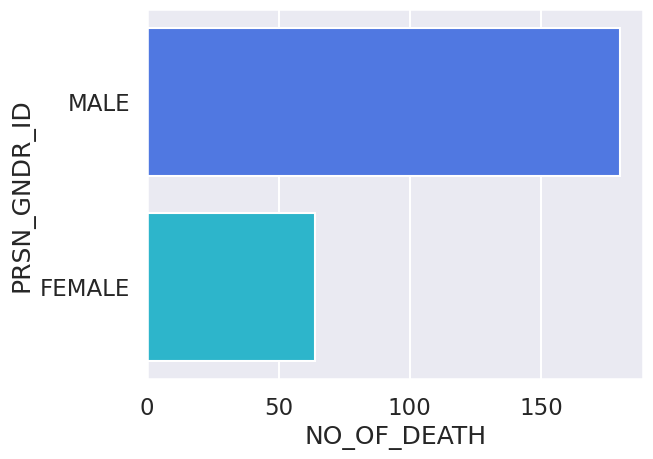

In [64]:
sns.barplot(x='NO_OF_DEATH',y='PRSN_GNDR_ID', data=crashGenderWise);
plt.savefig("Death.png")

In [60]:
topstatesfemaleacc = most_acc_female_df.withColumnRenamed("count","NO_OF_ACCIDENTS").toPandas().sort_values(by="NO_OF_ACCIDENTS",ascending=False).head(10)

In [61]:
topstatesfemaleacc

,DRVR_LIC_STATE_ID,NO_OF_ACCIDENTS
5,Texas,53319
17,Mexico,241
15,New Mexico,233
32,Louisiana,233
39,California,170
13,Oklahoma,157
35,Florida,153
3,Arkansas,115
18,Georgia,78
28,Arizona,77
